In [1]:
# Generative adversarial network on MNIST
# Reference
# https://blog.csdn.net/sparkexpert/article/details/70147409
# https://www.leiphone.com/news/201704/b8w2VNuvTV2CERMP.html

In [2]:
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import tensorflow as tf

/home/mzx/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Init
## Init
batch_size = 64

z_len = 100
z_noise = tf.placeholder(dtype=tf.float32, shape=[None, z_len], name='z_noise')
x_data = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='x_data')
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

In [5]:
# Generator
def generator(z_noise, keep_prob, namescope='generator'):
    """The generator"""
    with tf.name_scope(namescope):
        net = tf.layers.dense(z_noise, units=150, activation=tf.nn.relu, name='g_fc1')
        net = tf.nn.dropout(net, keep_prob=keep_prob)
        net = tf.layers.dense(net, units=300, activation=tf.nn.relu, name='g_fc2')
        net = tf.nn.dropout(net, keep_prob=keep_prob)
        net = tf.layers.dense(net, units=784, activation=tf.nn.sigmoid, name='g_fc3')
    return net

In [6]:
# descriminator
def discriminator(d_in, z_len, keep_prob, namescope='descriminator', reuse=True):
    """The descriminator"""
    with tf.name_scope(namescope):
        net = tf.layers.dense(d_in, units=300, activation=tf.nn.relu, name='d_fc1', reuse=reuse)
        net = tf.nn.dropout(net, keep_prob=keep_prob)
        net = tf.layers.dense(net, units=150, activation=tf.nn.relu, name='d_fc2', reuse=reuse)
        net = tf.nn.dropout(net, keep_prob=keep_prob)
        net = tf.layers.dense(net, units=1, activation=tf.nn.sigmoid, name='d_fc3', reuse=reuse)
        return net

In [7]:
# generate the network
x_g = generator(z_noise, keep_prob)
d_g = discriminator(x_g, z_len, keep_prob, reuse=False)
d_data = discriminator(x_data, z_len, keep_prob)

In [8]:
# get variables
varlist = tf.trainable_variables()
for v in varlist:
    print(v)

<tf.Variable 'g_fc1/kernel:0' shape=(100, 150) dtype=float32_ref>
<tf.Variable 'g_fc1/bias:0' shape=(150,) dtype=float32_ref>
<tf.Variable 'g_fc2/kernel:0' shape=(150, 300) dtype=float32_ref>
<tf.Variable 'g_fc2/bias:0' shape=(300,) dtype=float32_ref>
<tf.Variable 'g_fc3/kernel:0' shape=(300, 784) dtype=float32_ref>
<tf.Variable 'g_fc3/bias:0' shape=(784,) dtype=float32_ref>
<tf.Variable 'd_fc1/kernel:0' shape=(784, 300) dtype=float32_ref>
<tf.Variable 'd_fc1/bias:0' shape=(300,) dtype=float32_ref>
<tf.Variable 'd_fc2/kernel:0' shape=(300, 150) dtype=float32_ref>
<tf.Variable 'd_fc2/bias:0' shape=(150,) dtype=float32_ref>
<tf.Variable 'd_fc3/kernel:0' shape=(150, 1) dtype=float32_ref>
<tf.Variable 'd_fc3/bias:0' shape=(1,) dtype=float32_ref>


In [9]:
# The objective
with tf.name_scope("loss"):
    loss_d = - (tf.reduce_mean(tf.log(1e-8 + d_data)) + tf.reduce_mean(tf.log(1e-8 + 1 - d_g)))
    loss_g = - tf.reduce_mean(tf.log(1e-8 + d_g))
    train_op_g = tf.train.AdamOptimizer(0.00015).minimize(loss_g, var_list=varlist[0:6])
    train_op_d = tf.train.AdamOptimizer(0.00015).minimize(loss_d, var_list=varlist[6:])

In [10]:
# load data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True, validation_size=5000)

Extracting ../../conditional_vae/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../conditional_vae/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../conditional_vae/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../conditional_vae/MNIST_data/t10k-labels-idx1-ubyte.gz


In [11]:
def gen_noise(shape):
    z_noise = np.random.normal(0, 1.0, size=shape).astype(np.float32)
    return z_noise

In [12]:
# Train
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [13]:
import time

def get_timestamp():
    """Get time at present"""
    import time
    timestamp = time.strftime('%Y-%m-%d: %H:%M:%S', time.localtime(time.time()))
    return timestamp

In [14]:
for i in range(60000):
    batch = mnist.train.next_batch(batch_size=batch_size)
    batch_noise = gen_noise(shape=[batch_size, z_len])
    sess.run(train_op_g, feed_dict = {
        z_noise: batch_noise, keep_prob: 0.5})
    sess.run(train_op_d, feed_dict = {
        z_noise: batch_noise, x_data: batch[0], keep_prob: 0.5})    

    if not i % 2000:
        batch = mnist.validation.next_batch(batch_size=batch_size)
        ls_g, ls_d  = sess.run(
            [loss_g, loss_d], 
            feed_dict = {
                z_noise: batch_noise, x_data: batch[0], keep_prob: 1.0})
        
        t = get_timestamp()
        print("[{0}]".format(t), i, ls_g, ls_d)

[2018-04-15: 12:33:03] 0 0.87480694 1.1608615
[2018-04-15: 12:33:15] 2000 8.133472 0.0005021556
[2018-04-15: 12:33:27] 4000 6.7747035 0.0017501315
[2018-04-15: 12:33:41] 6000 5.8481007 0.029206038
[2018-04-15: 12:33:56] 8000 5.0878572 0.042589255
[2018-04-15: 12:34:09] 10000 3.3955417 0.19609886
[2018-04-15: 12:34:22] 12000 3.0956213 0.2164573
[2018-04-15: 12:34:36] 14000 3.1691284 0.24723443
[2018-04-15: 12:34:50] 16000 2.568102 0.31313083
[2018-04-15: 12:35:02] 18000 2.6128292 0.35386616
[2018-04-15: 12:35:14] 20000 2.6364837 0.3593006
[2018-04-15: 12:35:24] 22000 2.5890508 0.3770289
[2018-04-15: 12:35:35] 24000 2.6393209 0.34867206
[2018-04-15: 12:35:46] 26000 2.332483 0.33891705
[2018-04-15: 12:35:56] 28000 2.3794088 0.60213006
[2018-04-15: 12:36:06] 30000 2.432277 0.48829508
[2018-04-15: 12:36:17] 32000 2.3473816 0.44038966
[2018-04-15: 12:36:27] 34000 2.1914377 0.41126305
[2018-04-15: 12:36:37] 36000 2.3638182 0.5147563
[2018-04-15: 12:36:48] 38000 2.377563 0.4490135
[2018-04-15:

/home/mzx/.local/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


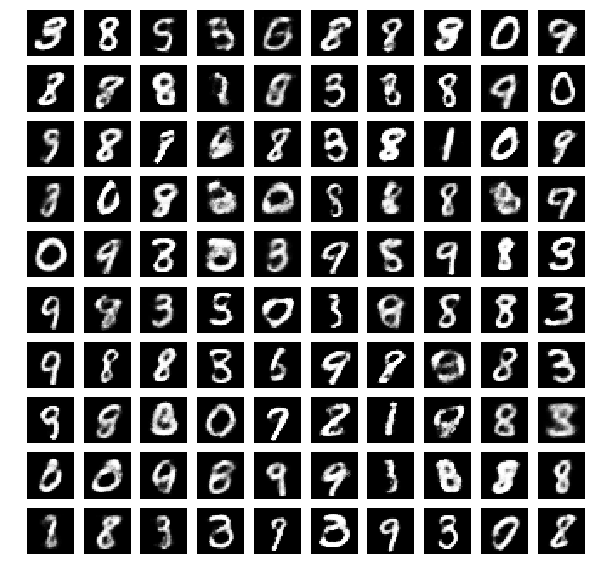

In [15]:
n_examples = 10

fig, axs = plt.subplots(10, n_examples, figsize=(n_examples, 10))
z1 = np.arange(0.0,1.0,0.01)
# z2 = z1
# z2 = np.repeat(np.arange(0.0,1.0,0.1), 10, axis=0)
# z = np.vstack([z2,z1]).T

for i in range(10):
    z_gen = gen_noise(shape=[n_examples,z_len])
    imgs = sess.run(x_g, 
                    # feed_dict = {z_noise: z[i*n_examples:(i+1)*n_examples,:], 
                    feed_dict = {z_noise: z_gen,
                                 keep_prob: 1.0})
    img_test = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]
    for example_i in range(n_examples):
        # original
        axs[i][example_i].imshow(img_test[example_i], cmap='gray')
        axs[i][example_i].axis('off')

fig.show()
plt.draw()